# ASCENSEUR ET ENTREPÔT AUTOMATIQUE

## Première partie : l'entrepôt

### Question 1

Chaque requête se réalise en 4 temps : il faut d'abord que l'ascenseur aille à l'étage de chargement du produit (temps $t_1$), ensuite il charge le produit (temps $\tau$), puis il se déplace vers l'étage de dépot (temps $t_2$) et enfin il décharge le produit (temps $\tau$). On a $t_2 \geq 1$, puisque le produit est déplacé d'au moins un étage. De plus, l'espérance d'un voyage (qui passe nécessairement par l'étage 0 que ce soit pour le chargement ou le déchargement) est de $\frac{L+1}{2}$

Une condition nécessaire de stabilité (presque sûre) est $\rho = \frac{2\lambda}{\mu} \leq 1$ (les deux types de demande suivent un processus de poisson d'intensité $\lambda$). Avec les bornes précédentes, on peut en déduire la condition nécessaire : $2\lambda (2\tau + \frac{L+1}{2}) \leq 1$

### Question 2

En régime permanent, le nombre moyen de tâches effectuées par unité de temps est nécessairement égal (à un coefficient multiplicateur dépendant de l'unité de temps choisi) à la fréquence d'arrivé des tâches $2\lambda$ (si il est inférieur, les tâches s'accumulent et on n'est pas en régime permanent tandis que l'inverse est impossible puisque la moyenne empirique d'arrivée des tâches tend vers $2\lambda$ et majore cet indicateur).

La loi de Little nous donne l'équivalence entre les indicateurs (i) et (iii) : le critère (iii) calcule $\bar{q}$, tandis que (iii) est égal à $\bar{\lambda}- 2\tau - \bar{t_2}$. L'espérance de $t_2$ étant $\frac{T}{2}$, la loi de Little donne : $(iii) = 2\lambda*((i) + 2\tau + \frac{T}{2})$. 

$T = 1$ et $\tau$ est une constante ce qui rend les deux indicateurs équivalents

### Question 3

In [1]:
"Simulation d'une M/M/m"

import heapq #on utilise une heap pour maintenir l'échéancier ; y place un élément en O(log n), récupère le premier en O(1)

#classe Système, contient le système, mais aussi l'échéancier
class System(object):
     
    def __init__(self, policy): # À un système on associe une politique de service. On ne la définit pas ici pour des raisons de modularité. 
        self.schedule = [] #échéancier
        self.queue = Queue() #file d'attente
        self.clients = [] #la liste des clients
        self.elevator = Elevator() #l'ascenseur
        self._policy = policy 
    
    """ATTENTION :  vu la façon donc le système a été encodé, l'ordre des étages n'est pas garanti.
                    Pour éviter tout problème, la politique (défini hors de la classe) renverra le numéro
                    de l'étage, et les méthodes suivantes permettront d'en extraire l'id du premier client"""
    def first_client(self, floor): #permet de récupérer l'id du premier client à un étage donné
        i = 0
        while (self.queue.attente[i].initial_floor != floor):
            print(self.queue.attente[i])
            i = i + 1
        return i
    
    def policy(self): #permet d'appeler la politique de service
        return self.first_client(self._policy(self))
    

        
class Elevator(object):

    def __init__(self):
        self.current_floor = 0

    def moving_time(self, destination_floor):
        return abs(destination_floor - self.current_floor)

#classe client        
class Client(object):
    
    def __init__(self, i, initial_floor, destination_floor):
        self.id = i #identifiant du client
        self.arrival = -1 #vaut -1 avant l'arrivée
        self.end_waiting = -1
        self.departure = -1 #vaut -1 tant qu'il n'est pas reparti
        self.initial_floor = initial_floor
        self.destination_floor = destination_floor
    
    def __str__(self):
        return f"Client {self.id} : arrivée à {self.arrival}, servi à {self.end_waiting}, fini à {self.departure}, étage initial {self.initial_floor}, étage final {self.destination_floor}"

#classe file d'attente
        
class Queue(object):
    
    def __init__(self):
        self.attente = [] #contient la liste des clients en attente
        self.service = [] #contient les clients en service
        
#classe événement

class Event(object):
    
    def __init__(self, time):
        self.time = time
        self.type = ""

#sous-classe "fin de simulation"

class Event_end(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "fin"

    def __lt__(self, other): # un problème sur heappop se pose lorsqu'on ajoute pas cela
        return self.time < other.time  

#sous-classe "arrivée d'un client"

class Event_arrival(Event):
    
    def __init__(self, time, initial_floor, destination_floor):
        self.time = time
        self.type = "arrival"
        self.initial_floor = initial_floor
        self.destination_floor = destination_floor
    
    def action(self, sys, parameters):
        client = Client(len(sys.clients), self.initial_floor, self.destination_floor) #on crée un client
        client.arrival = self.time
        sys.clients.append(client)  #on initialise et ajoute un client à la liste des clients
        
        if (len(sys.queue.service) == 0):
            client.end_waiting = self.time + abs(client.initial_floor - sys.elevator.current_floor)
            sys.queue.service.append(client)
            e_service = Event_end_service(client.id, self.time + abs(client.initial_floor - sys.elevator.current_floor) + service_time(client))
            heapq.heappush(sys.schedule, (e_service.time, e_service))  # Ne marche que si une fois un service terminé, on peut commencer immédiatement le suivant
        else:
            sys.queue.attente.append(client) #on ajoute le client à la file d'attente
        # on génère le prochain événement d'arrivée
        type_of_next_arrival = arrival_type(parameters) 
        e_next_arrival = Event_arrival(self.time + interarrival_time(parameters), type_of_next_arrival[0], type_of_next_arrival[1])
        heapq.heappush(sys.schedule, (e_next_arrival.time, e_next_arrival)) 


#sous-classe "départ d'un client"
            
class Event_end_service(Event):
    
    def __init__(self, i, time):
        self.time = time
        self.type = "service"
        self.client_id = i
    
    def action(self, sys, parameters):
        i = 0
        while (sys.queue.service[i].id != self.client_id):
            i = i + 1
        client = sys.queue.service.pop(i)
               
        client.departure = self.time  
        sys.elevator.current_floor = client.destination_floor ## pourquoi pas client.initial_floor ?
        
        if len(sys.queue.attente):
            next_client = sys.queue.attente.pop(sys.policy())
            next_client.end_waiting = self.time + abs(next_client.initial_floor - sys.elevator.current_floor)
            sys.elevator.current_floor = next_client.initial_floor
            sys.queue.service.append(next_client)
            e_service = Event_end_service(next_client.id, next_client.end_waiting + service_time(next_client, parameters))
            heapq.heappush(sys.schedule, (e_service.time, e_service))    

    ## Il ne faut pas générer un événement aussi comme dans Event_arrival ?

    def __lt__(self, other):# un problème sur heappop se pose lorsqu'on ajoute pas cela
        return self.time < other.time  

In [17]:
#Création d'un dictionnaire pour modularité
parameters = {
    "L": 7,  # nombre d'étages
    "NBR_SERVERS": 1,
    "LAMBDA": 0.09,  # intensité processus d'arrivées : nombre moyen d'arrivées par unité de temps
    "TAU": 1,
    "NBR_RUNS": 10,
    "CONFIDENCE_LEVEL": 95,  # pourcentage donnant le niveau de confiance des résultats
    "TOTAL_DURATION": 20000,  # durée totale simulée
    "TRANSIENT_DURATION": 10000,  # temps estimé pour arriver en régime transient
}
parameters["MU"] = 1.3/parameters["NBR_SERVERS"]

In [18]:
import random

def interarrival_time(parameters):
    return random.expovariate(parameters["LAMBDA"])

def service_time(client, parameters=parameters): # A MODIFIER
    return 2*parameters["TAU"] + abs(client.destination_floor - client.initial_floor)

def arrival_type(parameters): # Le type d'arrivée est déterminé par un tirage aléatoire entre un client qui monte (depuis l'étage E/S)
                                # et un client qui descend avec probabilité 1/2 (les deux ont un paramètre lambda identique)
    nbr_floor = parameters["L"]
    if random.random() < 0.5:
        return (0,random.randint(1, nbr_floor))
    return (random.randint(1, nbr_floor), 0)

POLITIQUES :

In [19]:
def FIFO(sys):
    return sys.queue.attente[0].initial_floor

In [20]:
"Lance la simulation, nombre de réplications donné par NBR_RUNS"

from statistics import mean 

waiting_times_run = [] #contient le temps moyen d'attente pour chaque run
sojourn_times_run = [] #contient le temps moyen de séjour pour chaque run

for i in range(parameters["NBR_RUNS"]):
    random.seed(i) #permet de la reproductibilité
    sys = System(FIFO)
    e_fin = Event_end(float(parameters["TOTAL_DURATION"]))
    heapq.heappush(sys.schedule, (e_fin.time, e_fin))
    e_debut_arrival_type = arrival_type(parameters)
    e_debut = Event_arrival(0, e_debut_arrival_type[0], e_debut_arrival_type[1])
    heapq.heappush(sys.schedule, (e_debut.time, e_debut))
    while sys.schedule[0][1].type != "fin":
        (time, e) = heapq.heappop(sys.schedule)
        e.action(sys, parameters)

    #TEST
    if (i==1):
        for k in range(10):
            print(sys.clients[k])
    
    waiting_times_clients = [] #temps d'attente par client pour le run i courant
    sojourn_times_clients = [] #temps de séjour par client pour le run i courant
    
    for j in range(len(sys.clients)):
        #on ne garde que les clients qui sont arrivés en régime permanent et qui ont quitté la file
        if sys.clients[j].departure != -1 and sys.clients[j].arrival >= parameters["TRANSIENT_DURATION"]:
            waiting_times_clients.append(sys.clients[j].end_waiting - sys.clients[j].arrival)
            sojourn_times_clients.append(sys.clients[j].departure - sys.clients[j].arrival)
    
    waiting_times_run.append(mean(waiting_times_clients))
    sojourn_times_run.append(mean(sojourn_times_clients))

print("temps moyen d'attente : ", mean(waiting_times_run))
print("temps moyen de séjour : ", mean(sojourn_times_run))

Client 0 : arrivée à 0, servi à 0, fini à 9, étage initial 0, étage final 7
Client 1 : arrivée à 3.2718190766029216, servi à 15, fini à 18, étage initial 1, étage final 0
Client 2 : arrivée à 10.373192183807394, servi à 18, fini à 24, étage initial 0, étage final 4
Client 3 : arrivée à 11.46831444449801, servi à 28, fini à 32, étage initial 0, étage final 2
Client 4 : arrivée à 16.957013775733067, servi à 34, fini à 43, étage initial 0, étage final 7
Client 5 : arrivée à 16.98043904462383, servi à 43, fini à 52, étage initial 7, étage final 0
Client 6 : arrivée à 34.96501346916495, servi à 52, fini à 60, étage initial 0, étage final 6
Client 7 : arrivée à 60.70904159045762, servi à 65.70904159045762, fini à 68.70904159045762, étage initial 1, étage final 0
Client 8 : arrivée à 72.35933280066521, servi à 72.35933280066521, fini à 75.35933280066521, étage initial 0, étage final 1
Client 9 : arrivée à 85.2471596719343, servi à 86.2471596719343, fini à 92.2471596719343, étage initial 0, ét

In [14]:
"Fait l'analyse"

from scipy.stats import t, sem

waiting_mean = mean(waiting_times_run)
waiting_sample_standard_error = sem(waiting_times_run)
confidence_interval = t.interval(parameters["CONFIDENCE_LEVEL"] / 100, parameters["NBR_RUNS"] - 1, waiting_mean, waiting_sample_standard_error)

print("Temps moyen d'attente : %.4f" % waiting_mean)
print("Intervalle de confiance à %d%%: " % parameters["CONFIDENCE_LEVEL"], end="") ; print("(%.4f, %.4f)" % confidence_interval) 

sojourn_mean = mean(sojourn_times_run)
sojourn_sample_standard_error = sem(sojourn_times_run)
confidence_interval = t.interval(parameters["CONFIDENCE_LEVEL"] / 100, parameters["NBR_RUNS"] - 1, sojourn_mean, sojourn_sample_standard_error)

print("Temps moyen de séjour : %.4f" % sojourn_mean)
print("Intervalle de confiance à %d%%: " % parameters["CONFIDENCE_LEVEL"], end="") ; print("(%.4f, %.4f)" % confidence_interval) 

Temps moyen d'attente : 4.2760
Intervalle de confiance à 95%: (4.0198, 4.5323)
Temps moyen de séjour : 10.2072
Intervalle de confiance à 95%: (9.9219, 10.4926)


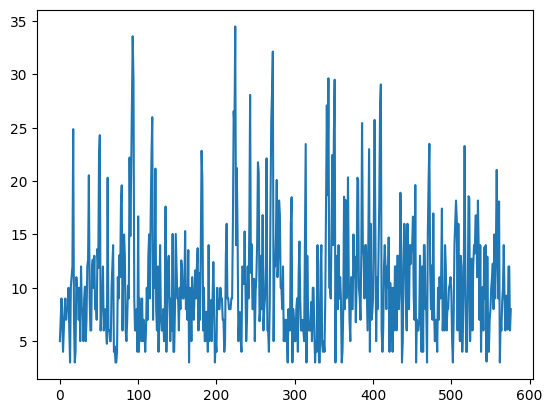

Moyenne empirique : 10.4553


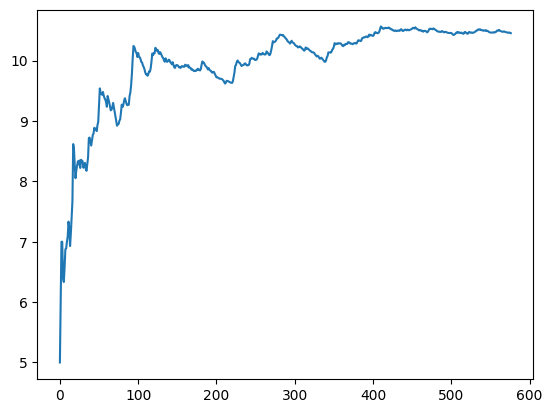

In [15]:
import matplotlib.pyplot as plt

average_sojourn_times = []
total = 0

sojourn_times_clients = []

for j in range(len(sys.clients)):
    if sys.clients[j].departure != -1:
        sojourn_times_clients.append(sys.clients[j].departure - sys.clients[j].arrival)

plt.plot(sojourn_times_clients)
plt.show()

for j in range(len(sojourn_times_clients)):
    total += sojourn_times_clients[j]
    average_sojourn_times.append(total / (j+1))

print("Moyenne empirique : %.4f" % average_sojourn_times[len(sojourn_times_clients)-1])

plt.plot(average_sojourn_times)
plt.show()

### Question 4


In [16]:
for LAMBDA in [0.01, 0.03, 0.05, 0.07, 0.09]:
    waiting_times_run = [] #contient le temps moyen d'attente pour chaque run
    sojourn_times_run = [] #contient le temps moyen de séjour pour chaque run
    parameters["LAMBDA"] = LAMBDA
    print("Lambda = ", LAMBDA)
    for i in range(parameters["NBR_RUNS"]):
        random.seed(i) #permet de la reproductibilité
        sys = System(FIFO)
        e_fin = Event_end(float(parameters["TOTAL_DURATION"]))
        heapq.heappush(sys.schedule, (e_fin.time, e_fin))
        e_debut_arrival_type = arrival_type(parameters)
        e_debut = Event_arrival(0, e_debut_arrival_type[0], e_debut_arrival_type[1])
        heapq.heappush(sys.schedule, (e_debut.time, e_debut))
        while sys.schedule[0][1].type != "fin":
            (time, e) = heapq.heappop(sys.schedule)
            e.action(sys, parameters)

        #TEST
        if (i==1):
            for k in range(10):
                print(sys.clients[k])
        
        waiting_times_clients = [] #temps d'attente par client pour le run i courant
        sojourn_times_clients = [] #temps de séjour par client pour le run i courant
        
        for j in range(len(sys.clients)):
            #on ne garde que les clients qui sont arrivés en régime permanent et qui ont quitté la file
            if sys.clients[j].departure != -1 and sys.clients[j].arrival >= parameters["TRANSIENT_DURATION"]:
                waiting_times_clients.append(sys.clients[j].end_waiting - sys.clients[j].arrival)
                sojourn_times_clients.append(sys.clients[j].departure - sys.clients[j].arrival)
        
        waiting_times_run.append(mean(waiting_times_clients))
        sojourn_times_run.append(mean(sojourn_times_clients))

    print("temps moyen d'attente : ", mean(waiting_times_run))
    print("temps moyen de séjour : ", mean(sojourn_times_run))

Lambda =  0.01
Client 0 : arrivée à 0, servi à 0, fini à 9, étage initial 0, étage final 7
Client 1 : arrivée à 29.446371689426293, servi à 35.44637168942629, fini à 38.44637168942629, étage initial 1, étage final 0
Client 2 : arrivée à 93.35872965426654, servi à 93.35872965426654, fini à 99.35872965426654, étage initial 0, étage final 4
Client 3 : arrivée à 103.21483000048208, servi à 107.21483000048208, fini à 111.21483000048208, étage initial 0, étage final 2
Client 4 : arrivée à 152.6131239815976, servi à 154.6131239815976, fini à 163.6131239815976, étage initial 0, étage final 7
Client 5 : arrivée à 152.82395140161444, servi à 163.6131239815976, fini à 172.6131239815976, étage initial 7, étage final 0
Client 6 : arrivée à 314.68512122248455, servi à 314.68512122248455, fini à 322.68512122248455, étage initial 0, étage final 6
Client 7 : arrivée à 546.3813743141186, servi à 551.3813743141186, fini à 554.3813743141186, étage initial 1, étage final 0
Client 8 : arrivée à 651.23399520